In [1]:
import tensorflow as tf
import os
import time
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from nilearn import image
from nilearn import plotting
import nibabel as nib
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from nilearn.image import concat_imgs, mean_img
# import graph_nets as gn
# import sonnet as snt 
# from graph_nets import blocks
# from graph_nets import graphs
# from graph_nets import modules
# from graph_nets import utils_np
# from graph_nets import utils_tf
import seaborn as sns
import matplotlib.pylab as plt

Matplotlib created a temporary config/cache directory at /tmp/pbs.4118881.pbsha.ib.sockeye/matplotlib-khow5f8e because the default path (/home/mkhademi/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Matplotlib is building the font cache; this may take a moment.


In [2]:
output_dir = '/scratch/st-ipor-1/mkhademi/'
subjs = ['CSI1', 'CSI2', 'CSI3', 'CSI4'] 
names = ['vehicle', 'animal', 'person', 'face', 'outdoor', 'sports', 'food', 'furniture', 'tool']
js = [91, 93, 0, 90, 92, 95, 97, 98, 102]
batch_size = 10
n_epochs = 60
def tf_parse(eg):
    example = tf.io.parse_example(
        eg, {
            'x': tf.io.FixedLenFeature(shape=(91, 109, 91, 1), dtype=tf.float32),
            'roi': tf.io.FixedLenFeature(shape=(16, 5085), dtype=tf.float32),
            'yhat': tf.io.FixedLenFeature(shape=(1000), dtype=tf.float32),
            'y_coco': tf.io.FixedLenFeature(shape=(90), dtype=tf.int64),
            'y_imagenet': tf.io.FixedLenFeature(shape=(1000), dtype=tf.int64),
            'y_super': tf.io.FixedLenFeature(shape=(12), dtype=tf.int64),
            'y_common': tf.io.FixedLenFeature(shape=(90+12+1), dtype=tf.int64)
        })
    return example['roi'], example['y_common']
def get_dataset(sub):
    dataset = tf.data.TFRecordDataset(
        filenames = [output_dir+'image_data/'+sub+'bold5000_common.tfrecords']).batch(batch_size)
    dataset = dataset.map(tf_parse)
    roi_names=['lFFA','rFFA','lOFA','rOFA','lSTS','rSTS','lLOC','rLOC','lPPA','rPPA','lRSC',
               'rRSC','lTOS','rTOS','lEBA','rEBA']
    return roi_names, dataset

In [3]:
def get_attn(dataset, j, n_epochs):
    train = dataset.map(lambda x, y: (x, tf.concat([y[:,j:j+1],
                        tf.ones_like(y[:,j:j+1],dtype=tf.int64)-y[:,j:j+1]],axis=1))) 
    inputs = tf.keras.Input(shape=(16, 5085))
    flt = tf.keras.layers.Flatten()
    inputs_flt = flt(inputs)
    
    dense_a = layers.Dense(16, activation=None)
    w_a = dense_a(inputs_flt)
    w_a = tf.reshape(w_a, [-1, 16, 1])
    w_a = tf.keras.layers.Softmax(axis=1, name='attn_a')(w_a)
    outputs_a = tf.repeat(w_a, 5085, axis=2) * inputs
    outputs_a = tf.math.reduce_sum(outputs_a, axis=1)
    outputs_a = tf.keras.layers.Dropout(rate=0.4)(outputs_a)
    outputs_a = layers.Dense(64, activation='relu')(outputs_a)
    
    dense_b = layers.Dense(16, activation=None)
    w_b = dense_b(inputs_flt)
    w_b = tf.reshape(w_b, [-1, 16, 1])
    w_b = tf.keras.layers.Softmax(axis=1, name='attn_b')(w_b)
    outputs_b = tf.repeat(w_b, 5085, axis=2) * inputs
    outputs_b = tf.math.reduce_sum(outputs_b, axis=1)
    outputs_b = tf.keras.layers.Dropout(rate=0.4)(outputs_b)
    outputs_b = layers.Dense(64, activation='relu')(outputs_b)
    
    outputs = tf.concat([outputs_a, outputs_b], 1)
    outputs = layers.Dense(2, activation=None)(outputs)
    outputs = tf.keras.layers.Softmax(axis=1)(outputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    # model.summary()
    model.compile(
        # loss='mse',
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        # loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
        # optimizer=keras.optimizers.RMSprop(),
        optimizer='adam',
        # metrics=[tf.keras.metrics.MeanSquaredError()],
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    model.fit(train, epochs=n_epochs) 
    layer_output_a = model.get_layer(name='attn_a').output
    attn_a = keras.Model(inputs=inputs, outputs=layer_output_a)
    layer_output_b = model.get_layer(name='attn_b').output
    attn_b = keras.Model(inputs=inputs, outputs=layer_output_b)
    return model, train, attn_a, attn_b
def get_wts(train, attn_a, attn_b, model):
    count = 0.0
    wts = np.zeros(16)
    for x, y in train:
        pred = model.predict(x)
        for j in range(y.shape[0]):
            if y[j][0] == 1 and pred[j][0] >= 0.5:
                count += 1
                tmp_a = attn_a.predict(x[j:j+1,:,:])[0][:,0]
                tmp_b = attn_b.predict(x[j:j+1,:,:])[0][:,0]
                wts += (np.copy(tmp_a) + np.copy(tmp_b))/2.0
    return wts/count

In [4]:
sub = subjs[0]
roi_names, dataset = get_dataset(sub)
all_wts = []
for idx, j in enumerate(js):
    model, train, attn_a, attn_b = get_attn(dataset, j, n_epochs)
    print('************************************')
    print(names[idx])
    wts = get_wts(train, attn_a, attn_b, model)
    print(wts)
    print('************************************')
    all_wts.append(wts)

2022-09-16 16:17:47.615271: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-16 16:17:47.673766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-09-16 16:17:47.885280: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-09-16 16:17:48.066070: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-16 16:17:48.084969: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-09-16 16:17:48.174882: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

Epoch 1/60


2022-09-16 16:17:50.497823: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


287/287 [==============================] - 11s 40ms/step - loss: 1.6027 - categorical_accuracy: 0.7874
Epoch 2/60
287/287 [==============================] - 8s 28ms/step - loss: 0.5874 - categorical_accuracy: 0.8177
Epoch 3/60
287/287 [==============================] - 8s 29ms/step - loss: 0.5862 - categorical_accuracy: 0.8296
Epoch 4/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4704 - categorical_accuracy: 0.8317
Epoch 5/60
287/287 [==============================] - 8s 28ms/step - loss: 0.4157 - categorical_accuracy: 0.8373
Epoch 6/60
287/287 [==============================] - 8s 28ms/step - loss: 0.4273 - categorical_accuracy: 0.8425
Epoch 7/60
287/287 [==============================] - 8s 28ms/step - loss: 0.3968 - categorical_accuracy: 0.8492
Epoch 8/60
287/287 [==============================] - 8s 28ms/step - loss: 0.3972 - categorical_accuracy: 0.8478
Epoch 9/60
287/287 [==============================] - 8s 28ms/step - loss: 0.3763 - categorical_accuracy: 

CSI1
[[0.466 0.017 0.128 0.027 0.    0.005 0.001 0.211 0.    0.102 0.    0.
  0.007 0.024 0.01  0.002]
 [0.001 0.001 0.004 0.015 0.02  0.    0.005 0.001 0.162 0.017 0.    0.324
  0.424 0.007 0.013 0.006]
 [0.309 0.012 0.    0.097 0.002 0.    0.    0.004 0.236 0.    0.006 0.
  0.298 0.031 0.    0.005]
 [0.48  0.    0.01  0.015 0.181 0.002 0.    0.005 0.009 0.011 0.    0.179
  0.003 0.106 0.    0.   ]
 [0.037 0.    0.002 0.002 0.005 0.    0.012 0.    0.    0.111 0.009 0.26
  0.339 0.002 0.221 0.   ]
 [0.007 0.01  0.01  0.    0.001 0.002 0.    0.    0.271 0.009 0.    0.4
  0.213 0.035 0.041 0.   ]
 [0.053 0.    0.    0.002 0.498 0.    0.    0.    0.    0.    0.    0.066
  0.004 0.374 0.004 0.   ]
 [0.058 0.056 0.07  0.    0.016 0.005 0.    0.002 0.009 0.362 0.    0.001
  0.008 0.411 0.    0.   ]
 [0.003 0.007 0.    0.004 0.008 0.003 0.    0.    0.    0.432 0.02  0.067
  0.    0.453 0.001 0.002]]


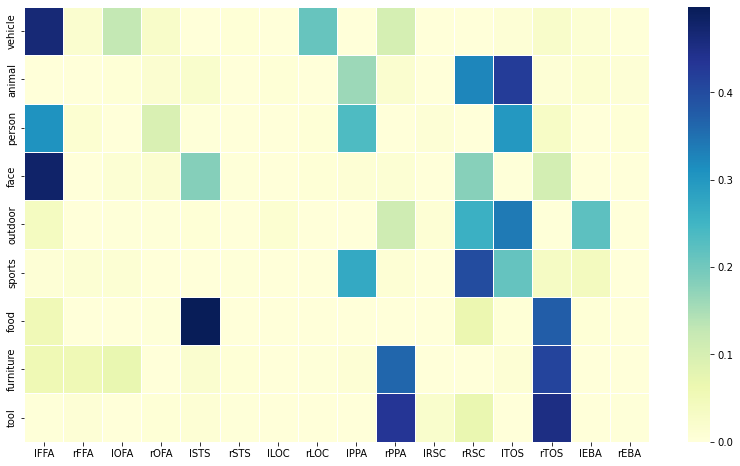

In [5]:
all_wts0 = all_wts
plt.rc('font', size=10)
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
all_wts = np.round(np.array(all_wts), decimals=3)
print(sub)
print(all_wts)
ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
ax.set_xticklabels(roi_names)
ax.set_yticklabels(names)
plt.show()

In [6]:
sub = subjs[1]
roi_names, dataset = get_dataset(sub)
all_wts = []
for idx, j in enumerate(js):
    model, train, attn_a, attn_b = get_attn(dataset, j, n_epochs)
    print('************************************')
    print(names[idx])
    wts = get_wts(train, attn_a, attn_b, model)
    print(wts)
    print('************************************')
    all_wts.append(wts)

Epoch 1/60
287/287 [==============================] - 9s 31ms/step - loss: 0.5177 - categorical_accuracy: 0.8059
Epoch 2/60
287/287 [==============================] - 8s 29ms/step - loss: 0.4290 - categorical_accuracy: 0.8314
Epoch 3/60
287/287 [==============================] - 8s 28ms/step - loss: 0.4230 - categorical_accuracy: 0.8376
Epoch 4/60
287/287 [==============================] - 8s 28ms/step - loss: 0.3853 - categorical_accuracy: 0.8446
Epoch 5/60
287/287 [==============================] - 8s 28ms/step - loss: 0.3822 - categorical_accuracy: 0.8506
Epoch 6/60
287/287 [==============================] - 8s 28ms/step - loss: 0.3902 - categorical_accuracy: 0.8502
Epoch 7/60
287/287 [==============================] - 8s 28ms/step - loss: 0.3548 - categorical_accuracy: 0.8607
Epoch 8/60
287/287 [==============================] - 8s 28ms/step - loss: 0.3274 - categorical_accuracy: 0.8694
Epoch 9/60
287/287 [==============================] - 8s 28ms/step - loss: 0.2950 - categorical_

CSI2
[[0.006 0.001 0.002 0.    0.483 0.006 0.    0.002 0.469 0.001 0.002 0.
  0.017 0.008 0.002 0.   ]
 [0.006 0.    0.    0.002 0.001 0.    0.003 0.    0.001 0.497 0.002 0.002
  0.003 0.    0.    0.485]
 [0.001 0.001 0.    0.    0.011 0.    0.002 0.    0.262 0.199 0.    0.
  0.229 0.272 0.001 0.022]
 [0.484 0.001 0.001 0.    0.001 0.    0.    0.002 0.494 0.009 0.    0.001
  0.    0.006 0.001 0.001]
 [0.44  0.    0.002 0.    0.    0.    0.    0.    0.002 0.026 0.    0.448
  0.    0.002 0.012 0.068]
 [0.    0.002 0.    0.    0.498 0.    0.001 0.    0.447 0.    0.    0.
  0.    0.048 0.005 0.   ]
 [0.004 0.001 0.481 0.004 0.484 0.005 0.005 0.    0.    0.004 0.    0.002
  0.    0.    0.    0.011]
 [0.012 0.    0.001 0.483 0.005 0.    0.    0.    0.002 0.    0.    0.495
  0.    0.    0.001 0.   ]
 [0.    0.    0.    0.487 0.001 0.483 0.    0.01  0.    0.002 0.002 0.
  0.    0.001 0.004 0.01 ]]


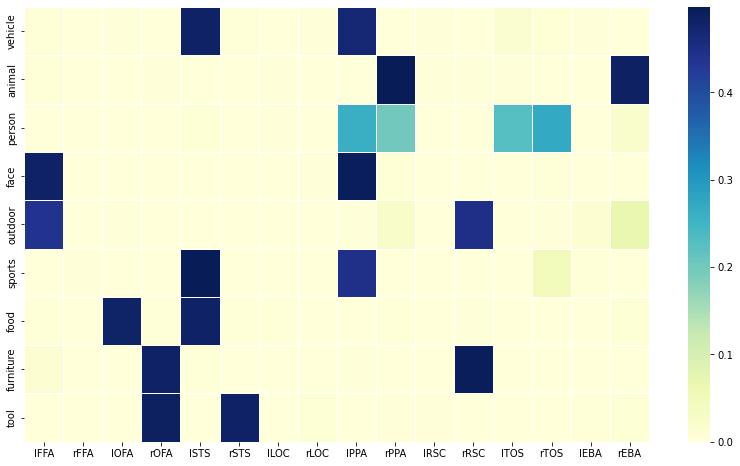

In [7]:
all_wts1 = all_wts
plt.rc('font', size=10)
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
all_wts = np.round(np.array(all_wts), decimals=3)
print(sub)
print(all_wts)
ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
ax.set_xticklabels(roi_names)
ax.set_yticklabels(names)
plt.show()

In [8]:
sub = subjs[2]
roi_names, dataset = get_dataset(sub)
all_wts = []
for idx, j in enumerate(js):
    model, train, attn_a, attn_b = get_attn(dataset, j, n_epochs)
    print('************************************')
    print(names[idx])
    wts = get_wts(train, attn_a, attn_b, model)
    print(wts)
    print('************************************')
    all_wts.append(wts)

Epoch 1/60
287/287 [==============================] - 8s 26ms/step - loss: 0.7321 - categorical_accuracy: 0.7799
Epoch 2/60
287/287 [==============================] - 8s 26ms/step - loss: 0.5040 - categorical_accuracy: 0.8225
Epoch 3/60
287/287 [==============================] - 8s 26ms/step - loss: 0.5500 - categorical_accuracy: 0.8351
Epoch 4/60
287/287 [==============================] - 7s 26ms/step - loss: 0.4496 - categorical_accuracy: 0.8393
Epoch 5/60
287/287 [==============================] - 8s 26ms/step - loss: 0.5636 - categorical_accuracy: 0.8361
Epoch 6/60
287/287 [==============================] - 8s 26ms/step - loss: 0.3580 - categorical_accuracy: 0.8557
Epoch 7/60
287/287 [==============================] - 7s 26ms/step - loss: 0.3364 - categorical_accuracy: 0.8662
Epoch 8/60
287/287 [==============================] - 7s 26ms/step - loss: 0.3299 - categorical_accuracy: 0.8718
Epoch 9/60
287/287 [==============================] - 7s 26ms/step - loss: 0.3213 - categorical_

CSI3
[[0.023 0.001 0.001 0.    0.194 0.004 0.001 0.    0.004 0.442 0.    0.009
  0.3   0.019 0.    0.001]
 [0.412 0.002 0.004 0.186 0.    0.    0.    0.001 0.033 0.01  0.005 0.114
  0.191 0.039 0.001 0.002]
 [0.186 0.    0.019 0.273 0.469 0.    0.    0.    0.    0.009 0.006 0.03
  0.003 0.004 0.    0.   ]
 [0.285 0.002 0.012 0.208 0.059 0.005 0.    0.012 0.07  0.001 0.    0.074
  0.21  0.06  0.004 0.001]
 [0.    0.005 0.114 0.    0.751 0.    0.002 0.    0.039 0.007 0.    0.011
  0.036 0.    0.002 0.032]
 [0.005 0.001 0.013 0.    0.019 0.005 0.    0.    0.023 0.451 0.002 0.464
  0.001 0.012 0.002 0.001]
 [0.181 0.    0.026 0.007 0.    0.    0.002 0.002 0.129 0.042 0.    0.426
  0.002 0.    0.181 0.002]
 [0.424 0.    0.053 0.067 0.    0.    0.    0.003 0.    0.003 0.021 0.388
  0.    0.005 0.018 0.019]
 [0.019 0.003 0.    0.004 0.    0.002 0.    0.    0.208 0.014 0.    0.321
  0.005 0.421 0.    0.002]]


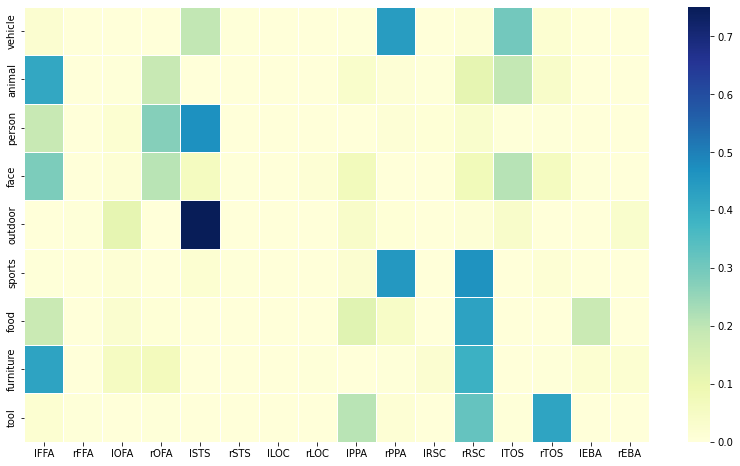

In [9]:
all_wts2 = all_wts
plt.rc('font', size=10)
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
all_wts = np.round(np.array(all_wts), decimals=3)
print(sub)
print(all_wts)
ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
ax.set_xticklabels(roi_names)
ax.set_yticklabels(names)
plt.show()

In [10]:
sub = subjs[3]
roi_names, dataset = get_dataset(sub)
all_wts = []
for idx, j in enumerate(js):
    model, train, attn_a, attn_b = get_attn(dataset, j, n_epochs)
    print('************************************')
    print(names[idx])
    wts = get_wts(train, attn_a, attn_b, model)
    print(wts)
    print('************************************')
    all_wts.append(wts)

Epoch 1/60
171/171 [==============================] - 5s 28ms/step - loss: 0.5720 - categorical_accuracy: 0.8078
Epoch 2/60
171/171 [==============================] - 5s 28ms/step - loss: 0.4544 - categorical_accuracy: 0.8389
Epoch 3/60
171/171 [==============================] - 5s 28ms/step - loss: 0.4480 - categorical_accuracy: 0.8354
Epoch 4/60
171/171 [==============================] - 5s 27ms/step - loss: 0.4062 - categorical_accuracy: 0.8477
Epoch 5/60
171/171 [==============================] - 5s 28ms/step - loss: 0.3749 - categorical_accuracy: 0.8530
Epoch 6/60
171/171 [==============================] - 5s 27ms/step - loss: 0.3583 - categorical_accuracy: 0.8671
Epoch 7/60
171/171 [==============================] - 5s 28ms/step - loss: 0.3049 - categorical_accuracy: 0.8807
Epoch 8/60
171/171 [==============================] - 5s 27ms/step - loss: 0.2779 - categorical_accuracy: 0.8865
Epoch 9/60
171/171 [==============================] - 5s 28ms/step - loss: 0.2594 - categorical_

CSI4
[[0.    0.    0.    0.007 0.484 0.007 0.007 0.003 0.    0.    0.    0.
  0.01  0.48  0.003 0.   ]
 [0.006 0.001 0.005 0.    0.478 0.001 0.001 0.    0.011 0.    0.    0.49
  0.004 0.    0.001 0.002]
 [0.492 0.002 0.    0.459 0.    0.    0.    0.    0.007 0.002 0.003 0.001
  0.027 0.    0.    0.008]
 [0.    0.    0.    0.001 0.001 0.    0.003 0.    0.    0.48  0.002 0.
  0.494 0.    0.001 0.018]
 [0.483 0.004 0.    0.    0.488 0.004 0.004 0.    0.    0.    0.004 0.004
  0.004 0.    0.    0.004]
 [0.    0.    0.016 0.006 0.004 0.    0.    0.    0.02  0.    0.002 0.482
  0.    0.    0.    0.47 ]
 [0.    0.476 0.    0.    0.489 0.014 0.003 0.    0.003 0.    0.    0.
  0.014 0.    0.003 0.   ]
 [0.    0.    0.    0.    0.496 0.    0.002 0.008 0.    0.002 0.    0.
  0.008 0.485 0.    0.   ]
 [0.002 0.002 0.492 0.002 0.495 0.    0.002 0.    0.    0.003 0.    0.
  0.003 0.    0.    0.   ]]


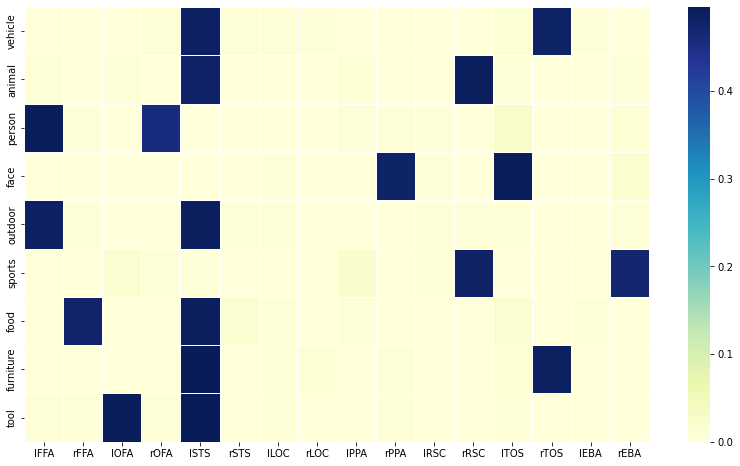

In [11]:
all_wts3 = all_wts
plt.rc('font', size=10)
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
all_wts = np.round(np.array(all_wts), decimals=3)
print(sub)
print(all_wts)
ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
ax.set_xticklabels(roi_names)
ax.set_yticklabels(names)
plt.show()

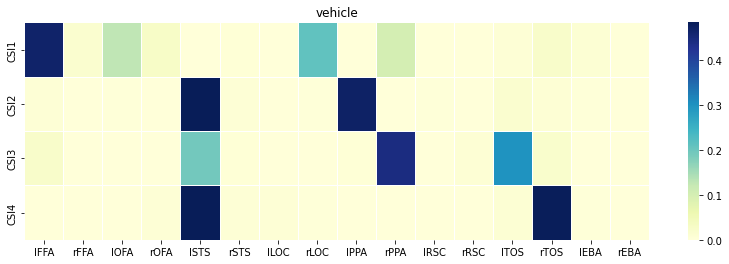

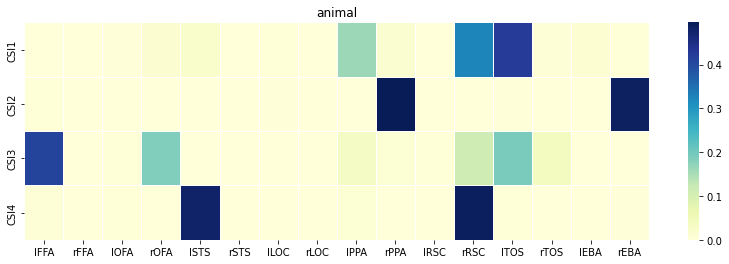

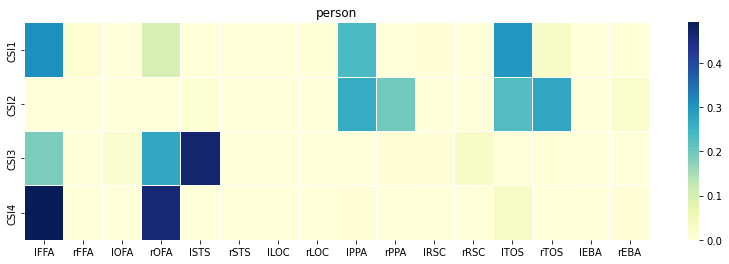

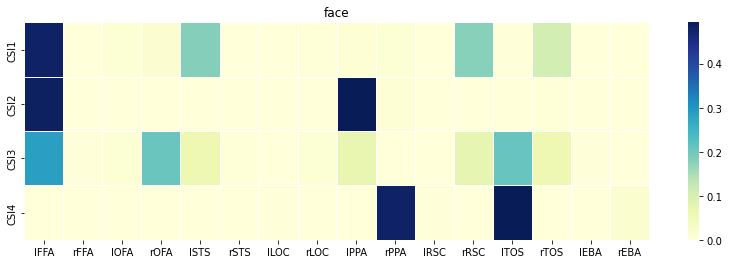

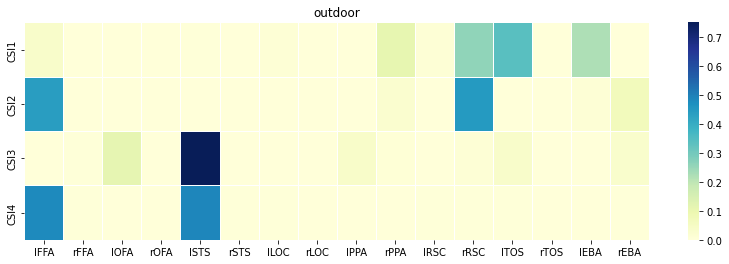

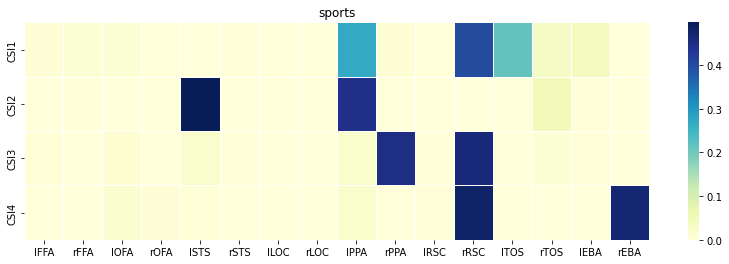

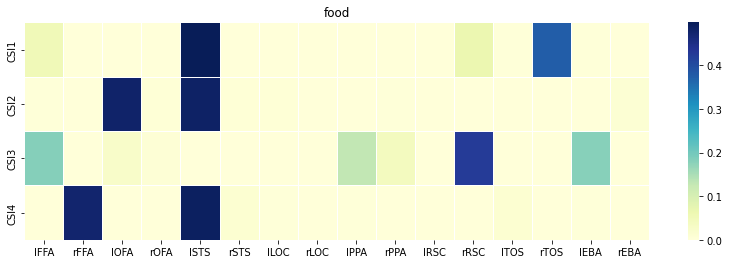

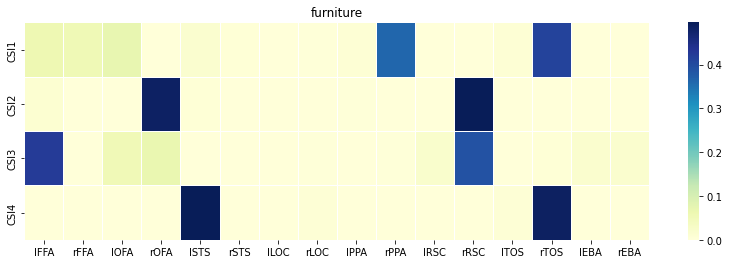

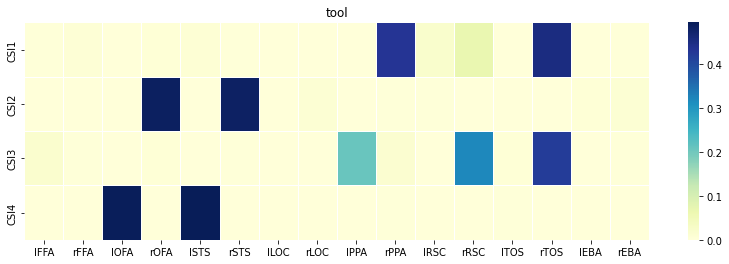

In [12]:
for i in range(len(names)):
    all_wts = np.array([all_wts0[i], all_wts1[i], all_wts2[i], all_wts3[i]])
    plt.rc('font', size=10)
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 4)
    ax = sns.heatmap(all_wts, linewidth=0.5, cmap="YlGnBu")
    ax.set_xticklabels(roi_names)
    ax.set_title(names[i])
    ax.set_yticklabels(subjs)
    plt.show()